## CSUS - CSc 177-02 Data Warehousing and Data Mining - Final Project:   
### 2016 U.S. presidential election Twitter analysis  

**Group members: Aaron Enberg, Nima Sarrafzadeh, Kyne Liu**  
**Professor: Haiquan (Victor) Chen**

In [50]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    preprocessing,  
    cluster as sk_cluster,
    metrics
)
from sklearn.metrics import classification_report
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import (
    RandomUnderSampler, 
    NearMiss, 
    EditedNearestNeighbours, 
    RepeatedEditedNearestNeighbours,
    CondensedNearestNeighbour,
    NeighbourhoodCleaningRule,
    OneSidedSelection,
    AllKNN,
    TomekLinks
)
from imblearn.combine import SMOTEENN
from imblearn.ensemble import EasyEnsemble, BalanceCascade
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
import sklearn.feature_extraction.text as sk_text
import gc

%matplotlib inline

pd.set_option('display.max_colwidth', -1)

In [3]:
daily_spotify = pd.read_csv('./data/data.csv')
daily_spotify.columns = ['position', 'track_name', 'artist', 'streams', 'url', 'date', 'region']

In [4]:
print(daily_spotify.shape)
print(daily_spotify.dtypes)

(3441197, 7)
position      int64 
track_name    object
artist        object
streams       int64 
url           object
date          object
region        object
dtype: object


In [5]:
daily_spotify.head()

,position,track_name,artist,streams,url,date,region
0,1,Reggaetón Lento (Bailemos),CNCO,19272,https://open.spotify.com/track/3AEZUABDXNtecAOSC1qTfo,2017-01-01,ec
1,2,Chantaje,Shakira,19270,https://open.spotify.com/track/6mICuAdrwEjh6Y6lroV2Kg,2017-01-01,ec
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,https://open.spotify.com/track/3QwBODjSEzelZyVjxPOHdq,2017-01-01,ec
3,4,Vente Pa' Ca,Ricky Martin,14954,https://open.spotify.com/track/7DM4BPaS7uofFul3ywMe46,2017-01-01,ec
4,5,Safari,J Balvin,14269,https://open.spotify.com/track/6rQSrBHf7HlZjtcMZ4S4bO,2017-01-01,ec


In [6]:
# keep only chart data from 2017
#daily_spotify = daily_spotify[(daily_spotify['date'] < '2018-01-01')]

In [7]:
daily_spotify['url'].nunique()

21746

In [8]:
daily_spotify['region'].unique()

array(['ec', 'fr', 'ar', 'fi', 'no', 'it', 'lt', 'ph', 'tw', 'nz', 'ee',
       'tr', 'us', 'sv', 'cr', 'de', 'cl', 'jp', 'br', 'hn', 'gt', 'ch',
       'hu', 'ca', 'pe', 'be', 'my', 'dk', 'bo', 'pl', 'at', 'pt', 'se',
       'mx', 'pa', 'uy', 'is', 'es', 'cz', 'ie', 'nl', 'sk', 'co', 'sg',
       'id', 'do', 'lu', 'gb', 'global', 'py', 'au', 'lv', 'gr', 'hk'],
      dtype=object)

In [9]:
#df = daily_spotify.groupby(['track_name', 'artist'])['region'].unique().to_frame()

In [10]:
#mlb = MultiLabelBinarizer()
#df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('region')),
#                          columns=mlb.classes_,
#                          index=df.index))

In [11]:
#daily_spotify.groupby(['track_name', 'artist'])['streams'].apply(sum).to_frame()

In [12]:
df_streams_by_country = daily_spotify.groupby(['track_name', 'artist', 'region', 'position', 'date'], as_index=False)['streams'].sum()

In [13]:
df_streams_by_country.head(n=10)

,track_name,artist,region,position,date,streams
0,"""All That Is or Ever Was or Ever Will Be""",Alan Silvestri,pl,185,2017-01-08,3547
1,"""All That Is or Ever Was or Ever Will Be""",Alan Silvestri,tr,198,2017-01-08,3764
2,"""Read All About It, Pt. III""",Emeli Sandé,be,147,2017-10-16,3330
3,"""Read All About It, Pt. III""",Emeli Sandé,be,159,2017-10-23,3334
4,"""Read All About It, Pt. III""",Emeli Sandé,be,182,2017-10-22,3179
5,"""Read All About It, Pt. III""",Emeli Sandé,be,186,2017-10-09,3075
6,"""Read All About It, Pt. III""",Emeli Sandé,be,192,2017-10-15,3053
7,"""Read All About It, Pt. III""",Emeli Sandé,cz,163,2017-10-16,1527
8,"""Read All About It, Pt. III""",Emeli Sandé,cz,174,2017-10-23,1458
9,"""Read All About It, Pt. III""",Emeli Sandé,cz,175,2017-10-22,1310


In [14]:
df = df_streams_by_country.pivot_table(index=['track_name', 'artist'], columns='region', values='streams', aggfunc=sum, fill_value=0)

In [15]:
df.reset_index(level=[0,1], inplace=True)

In [16]:
df['track_name_by_artist'] = df.track_name.str.cat(df.artist, sep=' ')

In [17]:
df.drop(['track_name', 'artist'], axis=1, inplace=True)

In [18]:
labels, levels = pd.factorize(df.track_name_by_artist)


In [19]:
df_streams_by_country['top10'] = np.where(df_streams_by_country['position'] <= 10, 1, 0)

In [20]:
df_streams_by_country['top10'].value_counts()

0    3244032
1    196508 
Name: top10, dtype: int64

In [21]:
df_top10 = df_streams_by_country.drop_duplicates(['track_name', 'artist', 'top10'])

In [22]:
df_top10 = df_top10.sort_values(['track_name', 'artist', 'top10'])

In [23]:
df_top10.drop_duplicates(['track_name', 'artist'], keep='last', inplace=True)

In [24]:
df_top10['top10'].value_counts()

0    18576
1    1346 
Name: top10, dtype: int64

In [25]:
df_top10.reset_index(level=0, drop=True, inplace=True)
df_top10.drop(['track_name', 'artist', 'region', 'position', 'date', 'streams'], axis=1, inplace=True)

In [26]:
df_top10.head()

,top10
0,0
1,0
2,0
3,0
4,0


In [27]:
df.head()

region,ar,at,au,be,bo,br,ca,ch,cl,co,...,py,se,sg,sk,sv,tr,tw,us,uy,track_name_by_artist
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3764,0,0,0,"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri"
1,0,0,0,15971,0,0,0,0,0,0,...,0,17307,0,0,0,0,0,0,0,"""Read All About It, Pt. III"" Emeli Sandé"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,#99 JVG
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,#Askip Black M
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,403591,0,0,0,#Biziz - feat. Lil Bege Reynmen


In [28]:
df.set_index('track_name_by_artist', inplace=True)

In [29]:
df.head()

region,ar,at,au,be,bo,br,ca,ch,cl,co,...,pt,py,se,sg,sk,sv,tr,tw,us,uy
track_name_by_artist,,,,,,,,,,,,,,,,,,,,,
"""All That Is or Ever Was or Ever Will Be"" Alan Silvestri",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3764,0,0,0
"""Read All About It, Pt. III"" Emeli Sandé",0,0,0,15971,0,0,0,0,0,0,...,0,0,17307,0,0,0,0,0,0,0
#99 JVG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#Askip Black M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#Biziz - feat. Lil Bege Reynmen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,403591,0,0,0


In [30]:
y = df_top10['top10']

In [31]:
y.value_counts()

0    18576
1    1346 
Name: top10, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15937, 54)
(3985, 54)
(15937,)
(3985,)


In [34]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.fit_transform(X_test)

In [ ]:
pca = PCA(n_components=2)

# Create the samplers
enn = EditedNearestNeighbours()
renn = RepeatedEditedNearestNeighbours()
ak = AllKNN(ratio='auto', kind_sel='mode', n_neighbors=3)
oss = OneSidedSelection()
ncr = NeighbourhoodCleaningRule()
nm = NearMiss()
rus = RandomUnderSampler()
# Create the classifier
k_range = list(range(1, 20))
params = {'n_neighbors': k_range}

''' weights='distance' weight points by the inverse of their distance. 
    in this case, closer neighbors of a query point will have a greater 
    influence than neighbors which are further away. 
    p=1 manhattan distance '''

knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', 
                           algorithm='auto', leaf_size=30, 
                           p=1, metric='minkowski', 
                           metric_params=None, n_jobs=1)

knn_grid_search_cv = GridSearchCV(knn, params, 
                                  cv=5, n_jobs=-1, 
                                  verbose=1, 
                                  scoring='f1_weighted')


Cs = np.logspace(-5, 15, num=11, base=2.0)
gammas = np.logspace(-15, 3, num=11, base=2.0)
print("Tested Cs", Cs)
print("Tested gammas", gammas)
param_grid = {'C': Cs, 'gamma': gammas}

# fit the model and get the separating hyperplane
svm_grid_search_cv = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=10)

# Add one transformers and two samplers in the pipeline object

pipeline = make_pipeline(pca, ak, svm_grid_search_cv)

pipeline.fit(X_train_scaled, y_train)
y_pred = pipeline.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

Tested Cs [3.1250e-02 1.2500e-01 5.0000e-01 2.0000e+00 8.0000e+00 3.2000e+01
 1.2800e+02 5.1200e+02 2.0480e+03 8.1920e+03 3.2768e+04]
Tested gammas [3.05175781e-05 1.06268379e-04 3.70047990e-04 1.28858194e-03
 4.48710295e-03 1.56250000e-02 5.44094102e-02 1.89464571e-01
 6.59753955e-01 2.29739671e+00 8.00000000e+00]


In [35]:
pca = PCA(n_components=2)

In [36]:
X_vis = pca.fit_transform(X_train_scaled)

In [43]:
ak = AllKNN()
X_resampled, y_resampled = ak.fit_sample(X_train_scaled, y_train)

In [44]:
clf_smote = LinearSVC().fit(X_resampled, y_resampled)

In [45]:
y_pred = clf_smote.predict(X_test_scaled)
print("Support Vector Machine classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

Support Vector Machine classification results

 F1-Score 
 0.6379928315412187

 Precision 
 0.624561403508772

 Recall 
 0.652014652014652

 Confusion Matrix 
 [[3605  107]
 [  95  178]]


In [104]:
svm_clf = SVC(C=5, kernel='rbf', degree=3, 
              gamma=.005, coef0=0.0, shrinking=True, 
              probability=False, tol=0.001, cache_size=200, 
              class_weight={0: 1, 1: 2}, verbose=False, max_iter=-1, 
              decision_function_shape='ovr', random_state=42)
svm_clf.fit(X_train_scaled, y_train)

SVC(C=5, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [105]:
y_pred = svm_clf.predict(X_test_scaled)
print("Support Vector Machine classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

Support Vector Machine classification results

 F1-Score 
 0.6586826347305389

 Precision 
 0.7236842105263158

 Recall 
 0.6043956043956044

 Confusion Matrix 
 [[3649   63]
 [ 108  165]]


In [47]:
linear_svm_clf = LinearSVC(penalty='l2', loss='squared_hinge', 
                           dual=True, tol=0.0001, C=1.0, 
                           multi_class='ovr', fit_intercept=True, 
                           intercept_scaling=1, class_weight=None, 
                           verbose=0, random_state=None, max_iter=1000)
linear_svm_clf.fit(X_train_scaled, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [48]:
y_pred = linear_svm_clf.predict(X_test_scaled)
print("Support Vector Machine classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

Support Vector Machine classification results

 F1-Score 
 0.5879629629629629

 Precision 
 0.7987421383647799

 Recall 
 0.4652014652014652

 Confusion Matrix 
 [[3680   32]
 [ 146  127]]


In [37]:
tree_clf = DecisionTreeClassifier(criterion='entropy', 
                                  splitter='best', 
                                  max_depth=None, 
                                  min_samples_split=2, 
                                  min_samples_leaf=1, 
                                  min_weight_fraction_leaf=0.0, 
                                  max_features=None, 
                                  random_state=42, 
                                  max_leaf_nodes=23, 
                                  min_impurity_decrease=0.0, 
                                  min_impurity_split=None, 
                                  class_weight='balanced', 
                                  presort=False)
tree_clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=23,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [38]:
y_pred = tree_clf.predict(X_test_scaled)
print("Decision Tree classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

Decision Tree classification results

 F1-Score 
 0.5270425776754891

 Precision 
 0.38422818791946306

 Recall 
 0.8388278388278388

 Confusion Matrix 
 [[3345  367]
 [  44  229]]


In [39]:
log_reg = LogisticRegression(penalty='l2', dual=False, 
                             tol=0.0001, C=.0094, 
                             fit_intercept=True, 
                             intercept_scaling=1, 
                             class_weight=None, 
                             random_state=42, 
                             solver='liblinear', 
                             max_iter=100, 
                             multi_class='ovr', 
                             verbose=0, 
                             warm_start=False, n_jobs=1)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=0.0094, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [40]:
y_pred = log_reg.predict(X_test_scaled)
print("Logistic Regression classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

Logistic Regression classification results

 F1-Score 
 0.538095238095238

 Precision 
 0.7687074829931972

 Recall 
 0.4139194139194139

 Confusion Matrix 
 [[3678   34]
 [ 160  113]]


In [58]:
k_range = list(range(1, 20))
params = {'n_neighbors': k_range}

''' weights='distance' weight points by the inverse of their distance. 
    in this case, closer neighbors of a query point will have a greater 
    influence than neighbors which are further away. 
    p=1 manhattan distance '''

knn = KNeighborsClassifier(n_neighbors=1, weights='distance', 
                           algorithm='auto', leaf_size=30, 
                           p=1, metric='minkowski', 
                           metric_params=None, n_jobs=1)

knn_grid_search_cv = GridSearchCV(knn, params, 
                                  cv=5, n_jobs=-1, 
                                  verbose=1, 
                                  scoring='f1_weighted')

knn_grid_search_cv.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 19 candidates, totalling 95 fits


KeyboardInterrupt: 

In [42]:
means = knn_grid_search_cv.cv_results_['mean_test_score']
for mean, params in zip(means, knn_grid_search_cv.cv_results_['params']):
    print(mean, params)

0.9478951293069692 {'n_neighbors': 1}
0.9478951293069692 {'n_neighbors': 2}
0.9501607646864416 {'n_neighbors': 3}
0.9508315687005708 {'n_neighbors': 4}
0.9505371777009809 {'n_neighbors': 5}
0.9512601158084967 {'n_neighbors': 6}
0.9511928772986193 {'n_neighbors': 7}
0.9514120827706062 {'n_neighbors': 8}
0.9514882875004186 {'n_neighbors': 9}
0.9512691611502672 {'n_neighbors': 10}
0.950787887902469 {'n_neighbors': 11}
0.951601988172136 {'n_neighbors': 12}
0.9515004144186484 {'n_neighbors': 13}
0.9512750285445106 {'n_neighbors': 14}
0.9508600813797381 {'n_neighbors': 15}
0.9509520498512115 {'n_neighbors': 16}
0.9504264668155142 {'n_neighbors': 17}
0.9509239013189499 {'n_neighbors': 18}
0.9504999584342608 {'n_neighbors': 19}


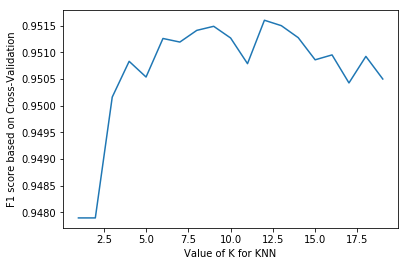

In [43]:
plt.plot(k_range, means)
plt.xlabel('Value of K for KNN')
plt.ylabel('F1 score based on Cross-Validation')
plt.show()

In [44]:
print(knn_grid_search_cv.best_score_)
print(knn_grid_search_cv.best_params_)
print(knn_grid_search_cv.best_estimator_)

0.951601988172136
{'n_neighbors': 12}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=1,
           weights='distance')


In [45]:
y_pred = knn_grid_search_cv.predict(X_test_scaled)
print("k-Nearest Neighbors classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

k-Nearest Neighbors classification results

 F1-Score 
 0.6085011185682327

 Precision 
 0.7816091954022989

 Recall 
 0.4981684981684982

 Confusion Matrix 
 [[3674   38]
 [ 137  136]]


In [55]:
sm = SMOTE(ratio='auto', random_state=None, 
           k=None, k_neighbors=5, m=None, 
           m_neighbors=10, out_step=0.5, 
           kind='regular', svm_estimator=None, 
           n_jobs=1)

smote_enn = SMOTEENN(smote = sm)

pipeline = make_pipeline(smote_enn, knn)

In [59]:
params = {'n_neighbors': k_range}
knn_grid_search_cv = GridSearchCV(pipeline, param_grid=params, 
                                  cv=5, n_jobs=-1, 
                                  verbose=1, 
                                  scoring='f1_weighted')

In [60]:
knn_grid_search_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f7e3890a5d0, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/aaron/.virtualenvs/CSc177/lib/python3.5/si...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/aaron/.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f7e3890a5d0, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/aaron/.virtualenvs/CSc177/lib/python3.5/si...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/aaron/.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'knn_grid_search_cv.fit(X_train_scaled, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 26, 3, 52, 39, 20823, tzinfo=tzutc()), 'msg_id': '66AE4D18F05D4A76B0AA5F6EAC3F5260', 'msg_type': 'execute_request', 'session': '95E35BA5718A4F9F8F426EFBBD8A2FC3', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '66AE4D18F05D4A76B0AA5F6EAC3F5260', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'95E35BA5718A4F9F8F426EFBBD8A2FC3']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'knn_grid_search_cv.fit(X_train_scaled, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 26, 3, 52, 39, 20823, tzinfo=tzutc()), 'msg_id': '66AE4D18F05D4A76B0AA5F6EAC3F5260', 'msg_type': 'execute_request', 'session': '95E35BA5718A4F9F8F426EFBBD8A2FC3', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '66AE4D18F05D4A76B0AA5F6EAC3F5260', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'95E35BA5718A4F9F8F426EFBBD8A2FC3'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'knn_grid_search_cv.fit(X_train_scaled, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 26, 3, 52, 39, 20823, tzinfo=tzutc()), 'msg_id': '66AE4D18F05D4A76B0AA5F6EAC3F5260', 'msg_type': 'execute_request', 'session': '95E35BA5718A4F9F8F426EFBBD8A2FC3', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '66AE4D18F05D4A76B0AA5F6EAC3F5260', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='knn_grid_search_cv.fit(X_train_scaled, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'knn_grid_search_cv.fit(X_train_scaled, y_train)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('knn_grid_search_cv.fit(X_train_scaled, y_train)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('knn_grid_search_cv.fit(X_train_scaled, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='knn_grid_search_cv.fit(X_train_scaled, y_train)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-60-51b06374c5cb>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f7de95d2588, executi..._before_exec=None error_in_exec=None result=None>)
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])
   2855                 code = compiler(mod, cell_name, "single")
-> 2856                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f7de9316a50, file "<ipython-input-60-51b06374c5cb>", line 1>
        result = <ExecutionResult object at 7f7de95d2588, executi..._before_exec=None error_in_exec=None result=None>
   2857                     return True
   2858 
   2859             # Flush softspace
   2860             if softspace(sys.stdout, 0):

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f7de9316a50, file "<ipython-input-60-51b06374c5cb>", line 1>, result=<ExecutionResult object at 7f7de95d2588, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f7de9316a50, file "<ipython-input-60-51b06374c5cb>", line 1>
        self.user_global_ns = {'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport ma...line')\n\npd.set_option('display.max_colwidth', -1)", "daily_spotify = pd.read_csv('./data/data.csv')\nd...e', 'artist', 'streams', 'url', 'date', 'region']", 'print(daily_spotify.shape)\nprint(daily_spotify.dtypes)', 'daily_spotify.head()', "# keep only chart data from 2017\n#daily_spotify ...y_spotify[(daily_spotify['date'] < '2018-01-01')]", "daily_spotify['url'].nunique()", "daily_spotify['region'].unique()", "#df = daily_spotify.groupby(['track_name', 'artist'])['region'].unique().to_frame()", '#mlb = MultiLabelBinarizer()\n#df = df.join(pd.Da...ses_,\n#                          index=df.index))', "#daily_spotify.groupby(['track_name', 'artist'])['streams'].apply(sum).to_frame()", "df_streams_by_country = daily_spotify.groupby(['...ition', 'date'], as_index=False)['streams'].sum()", 'df_streams_by_country.head(n=10)', "df = df_streams_by_country.pivot_table(index=['t...on', values='streams', aggfunc=sum, fill_value=0)", 'df.reset_index(level=[0,1], inplace=True)', "df['track_name_by_artist'] = df.track_name.str.cat(df.artist, sep=' ')", "df.drop(['track_name', 'artist'], axis=1, inplace=True)", 'labels, levels = pd.factorize(df.track_name_by_artist)', "df_streams_by_country['top10'] = np.where(df_streams_by_country['position'] <= 10, 1, 0)", "df_streams_by_country['top10'].value_counts()", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MultiLabelBinarizer': <class 'sklearn.preprocessing.label.MultiLabelBinarizer'>, 'Out': {4:    position                  track_name         ...track/6rQSrBHf7HlZjtcMZ4S4bO  2017-01-01  ec     , 6: 21746, 7: array(['ec', 'fr', 'ar', 'fi', 'no', 'it', 'lt',...py', 'au', 'lv', 'gr', 'hk'],
      dtype=object), 12:                                   track_name    ...8  2017-10-23  1458     
9  2017-10-22  1310     , 19: 0    3244032
1    196508 
Name: top10, dtype: int64, 23: 0    18576
1    1346 
Name: top10, dtype: int64, 25:    top10
0  0    
1  0    
2  0    
3  0    
4  0    , 26: region  ar  at  au     be  bo  br  ca  ch  cl  c...                          

[5 rows x 55 columns], 28: region                                          ...      403591  0   0   0   

[5 rows x 54 columns], 30: 0        0
1        0
2        0
3        0
4   ...921    0
Name: top10, Length: 19922, dtype: int64, ...}, 'Pipeline': <class 'imblearn.pipeline.Pipeline'>, 'SMOTE': <class 'imblearn.over_sampling.smote.SMOTE'>, ...}
        self.user_ns = {'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport ma...line')\n\npd.set_option('display.max_colwidth', -1)", "daily_spotify = pd.read_csv('./data/data.csv')\nd...e', 'artist', 'streams', 'url', 'date', 'region']", 'print(daily_spotify.shape)\nprint(daily_spotify.dtypes)', 'daily_spotify.head()', "# keep only chart data from 2017\n#daily_spotify ...y_spotify[(daily_spotify['date'] < '2018-01-01')]", "daily_spotify['url'].nunique()", "daily_spotify['region'].unique()", "#df = daily_spotify.groupby(['track_name', 'artist'])['region'].unique().to_frame()", '#mlb = MultiLabelBinarizer()\n#df = df.join(pd.Da...ses_,\n#                          index=df.index))', "#daily_spotify.groupby(['track_name', 'artist'])['streams'].apply(sum).to_frame()", "df_streams_by_country = daily_spotify.groupby(['...ition', 'date'], as_index=False)['streams'].sum()", 'df_streams_by_country.head(n=10)', "df = df_streams_by_country.pivot_table(index=['t...on', values='streams', aggfunc=sum, fill_value=0)", 'df.reset_index(level=[0,1], inplace=True)', "df['track_name_by_artist'] = df.track_name.str.cat(df.artist, sep=' ')", "df.drop(['track_name', 'artist'], axis=1, inplace=True)", 'labels, levels = pd.factorize(df.track_name_by_artist)', "df_streams_by_country['top10'] = np.where(df_streams_by_country['position'] <= 10, 1, 0)", "df_streams_by_country['top10'].value_counts()", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MultiLabelBinarizer': <class 'sklearn.preprocessing.label.MultiLabelBinarizer'>, 'Out': {4:    position                  track_name         ...track/6rQSrBHf7HlZjtcMZ4S4bO  2017-01-01  ec     , 6: 21746, 7: array(['ec', 'fr', 'ar', 'fi', 'no', 'it', 'lt',...py', 'au', 'lv', 'gr', 'hk'],
      dtype=object), 12:                                   track_name    ...8  2017-10-23  1458     
9  2017-10-22  1310     , 19: 0    3244032
1    196508 
Name: top10, dtype: int64, 23: 0    18576
1    1346 
Name: top10, dtype: int64, 25:    top10
0  0    
1  0    
2  0    
3  0    
4  0    , 26: region  ar  at  au     be  bo  br  ca  ch  cl  c...                          

[5 rows x 55 columns], 28: region                                          ...      403591  0   0   0   

[5 rows x 54 columns], 30: 0        0
1        0
2        0
3        0
4   ...921    0
Name: top10, Length: 19922, dtype: int64, ...}, 'Pipeline': <class 'imblearn.pipeline.Pipeline'>, 'SMOTE': <class 'imblearn.over_sampling.smote.SMOTE'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/aaron/dev/CSc177/spotify-charts/<ipython-input-60-51b06374c5cb> in <module>()
----> 1 knn_grid_search_cv.fit(X_train_scaled, y_train)

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...='warn',
       scoring='f1_weighted', verbose=1), X=array([[-0.09733547, -0.117291  , -0.11123174, .... -0.03722762,
        -0.11748239, -0.09951198]]), y=19050    0
17662    0
17878    0
7365     0
8242...795    0
Name: top10, Length: 15937, dtype: int64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=5, random_state=None, shuffle=False)>
        X = array([[-0.09733547, -0.117291  , -0.11123174, .... -0.03722762,
        -0.11748239, -0.09951198]])
        y = 19050    0
17662    0
17878    0
7365     0
8242...795    0
Name: top10, Length: 15937, dtype: int64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Apr 25 20:52:39 2018
PID: 7230         Python 3.5.3: /home/aaron/.virtualenvs/CSc177/bin/python3
...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('smoteenn', S...ighbors=1, p=1,
           weights='distance'))]), memmap([[-0.09733547, -0.117291  , -0.11123174, ...-0.03722762,
         -0.11748239, -0.09951198]]), 19050    0
17662    0
17878    0
7365     0
8242...795    0
Name: top10, Length: 15937, dtype: int64, {'score': make_scorer(f1_score, pos_label=None, average=weighted)}, array([ 3175,  3176,  3178, ..., 15934, 15935, 15936]), array([   0,    1,    2, ..., 3376, 3384, 3404]), 1, {'n_neighbors': 1}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('smoteenn', S...ighbors=1, p=1,
           weights='distance'))]), memmap([[-0.09733547, -0.117291  , -0.11123174, ...-0.03722762,
         -0.11748239, -0.09951198]]), 19050    0
17662    0
17878    0
7365     0
8242...795    0
Name: top10, Length: 15937, dtype: int64, {'score': make_scorer(f1_score, pos_label=None, average=weighted)}, array([ 3175,  3176,  3178, ..., 15934, 15935, 15936]), array([   0,    1,    2, ..., 3376, 3384, 3404]), 1, {'n_neighbors': 1})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('smoteenn', S...ighbors=1, p=1,
           weights='distance'))]), X=memmap([[-0.09733547, -0.117291  , -0.11123174, ...-0.03722762,
         -0.11748239, -0.09951198]]), y=19050    0
17662    0
17878    0
7365     0
8242...795    0
Name: top10, Length: 15937, dtype: int64, scorer={'score': make_scorer(f1_score, pos_label=None, average=weighted)}, train=array([ 3175,  3176,  3178, ..., 15934, 15935, 15936]), test=array([   0,    1,    2, ..., 3376, 3384, 3404]), verbose=1, parameters={'n_neighbors': 1}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method Pipeline.set_params of Pipeline(me...ghbors=1, p=1,
           weights='distance'))])>
        parameters = {'n_neighbors': 1}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/pipeline.py in set_params(self=Pipeline(memory=None,
     steps=[('smoteenn', S...ighbors=1, p=1,
           weights='distance'))]), **kwargs={'n_neighbors': 1})
    137 
    138         Returns
    139         -------
    140         self
    141         """
--> 142         self._set_params('steps', **kwargs)
        self._set_params = <bound method _BaseComposition._set_params of Pi...ghbors=1, p=1,
           weights='distance'))])>
        kwargs = {'n_neighbors': 1}
    143         return self
    144 
    145     def _validate_steps(self):
    146         names, estimators = zip(*self.steps)

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/utils/metaestimators.py in _set_params(self=Pipeline(memory=None,
     steps=[('smoteenn', S...ighbors=1, p=1,
           weights='distance'))]), attr='steps', **params={'n_neighbors': 1})
     44         names, _ = zip(*getattr(self, attr))
     45         for name in list(six.iterkeys(params)):
     46             if '__' not in name and name in names:
     47                 self._replace_estimator(attr, name, params.pop(name))
     48         # 3. Step parameters and other initilisation arguments
---> 49         super(_BaseComposition, self).set_params(**params)
        self.set_params = <bound method Pipeline.set_params of Pipeline(me...ghbors=1, p=1,
           weights='distance'))])>
        params = {'n_neighbors': 1}
     50         return self
     51 
     52     def _replace_estimator(self, attr, name, new_val):
     53         # assumes `name` is a valid estimator name

...........................................................................
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/base.py in set_params(self=Pipeline(memory=None,
     steps=[('smoteenn', S...ighbors=1, p=1,
           weights='distance'))]), **params={'n_neighbors': 1})
    269             key, delim, sub_key = key.partition('__')
    270             if key not in valid_params:
    271                 raise ValueError('Invalid parameter %s for estimator %s. '
    272                                  'Check the list of available parameters '
    273                                  'with `estimator.get_params().keys()`.' %
--> 274                                  (key, self))
        key = 'n_neighbors'
        self = Pipeline(memory=None,
     steps=[('smoteenn', S...ighbors=1, p=1,
           weights='distance'))])
    275 
    276             if delim:
    277                 nested_params[key][sub_key] = value
    278             else:

ValueError: Invalid parameter n_neighbors for estimator Pipeline(memory=None,
     steps=[('smoteenn', SMOTEENN(enn=None, k=None, kind_enn=None, kind_smote=None, m=None,
     n_jobs=None, n_neighbors=None, out_step=None, random_state=None,
     ratio='auto', size_ngh=None,
     smote=SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, ra...wski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='distance'))]). Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________

In [65]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train_scaled, y_train)

/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [64]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [66]:
y_pred = clf_rf.predict(X_test_scaled)

In [67]:
print("Random Forest classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

Random Forest classification results

 F1-Score 
 0.07746478873239436

 Precision 
 1.0

 Recall 
 0.040293040293040296

 Confusion Matrix 
 [[3712    0]
 [ 262   11]]


In [109]:
pipe = Pipeline([
    ('oversample', SMOTE(random_state=444)),
    ('clf', knn)
    ])

skf = StratifiedKFold()
param_grid = {'clf__n_neighbors': k_range}
grid = GridSearchCV(pipe, param_grid, return_train_score=False,
                    n_jobs=-1, scoring='roc_auc', cv=skf)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('oversample', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=444, ratio='auto', svm_estimator=None)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='distance'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=0)

In [110]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9459412520404455
{'clf__n_neighbors': 19}
Pipeline(memory=None,
     steps=[('oversample', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=444, ratio='auto', svm_estimator=None)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=1,
           weights='distance'))])


In [111]:
y_pred = grid.predict(X_test_scaled)
print("k-Nearest Neighbors classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

k-Nearest Neighbors classification results

 F1-Score 
 0.0

 Precision 
 0.0

 Recall 
 0.0

 Confusion Matrix 
 [[3712    0]
 [ 273    0]]


/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aaron/.virtualenvs/CSc177/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
